# Notebook Objectives
0. Boilerplate
1. Load and format data
2. Inspect data
3. Prepare data for clustering
4. Cluster with KMeans algorithm
5. Cluster with Agglomerative algorithm
6. Compare clustering results to iris species
7. Descriptive analysis

# 0. Boilerplate
## Imports

In [1]:
# standard library imports
from typing import List, Tuple, Union
# third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.utils import Bunch
# make it pretty
plt.style.use('seaborn-whitegrid')

## Set random state for repeatability

In [2]:
random_state = 97

## Helper functions

In [3]:
def format_data(iris: Bunch) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Loads iris data and creates x and y DataFrames"""
    df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
    df['target'] = iris.target
    df['target_name'] = df['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})
    df.columns = [col.replace(' ', '_').replace('(cm)', 'cm') for col in df.columns]
    x = df.loc[:, df.columns[0:4]]
    y = df.loc[:, df.columns[4:]]
    return x, y


def scale_x(x: pd.DataFrame, scaler: StandardScaler) -> pd.DataFrame:
    """Scales x with mean and std dev returning a scaled DataFrame"""
    x_scaled = pd.DataFrame(data=scaler.fit_transform(x), columns=x.columns)
    return x_scaled


def elbow_plot(
    x: pd.DataFrame,
    clusters: List[int],
    random_state: int,
) -> None:
    """Creates and elbow plot for KMeans clustering using distortion"""
    distortions = []
    for n in clusters:
        kmeans = KMeans(n_clusters=n, random_state=random_state)
        kmeans.fit(x)
        distortions.append(kmeans.inertia_)
    plt.figure(figsize=(12, 6))
    plt.scatter(
        x=clusters,
        y=distortions
    )
    plt.xticks(clusters)
    plt.ylabel('Distortion', fontsize=12)
    plt.xlabel('Number of clusters', fontsize=12)
    plt.title('Distortion vs number of clusters', fontsize=16);


def plot_clusters(model: Union[KMeans, AgglomerativeClustering]) -> None:
    """Plots clusters with a different color for each label"""
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    for v in np.unique(model.labels_):
        axs[0].scatter(
            x=x.loc[model.labels_ == v, 'sepal_length_cm'],
            y=x.loc[model.labels_ == v, 'sepal_width_cm'],
            label=v
        )
        axs[1].scatter(
            x=x.loc[model.labels_ == v, 'petal_length_cm'],
            y=x.loc[model.labels_ == v, 'petal_width_cm'],
            label=v
        )
    axs[0].set_xlabel('sepal length', fontsize=12)
    axs[0].set_ylabel('sepal width', fontsize=12)
    axs[1].set_xlabel('petal length', fontsize=12)
    axs[1].set_ylabel('petal width', fontsize=12)
    axs[0].legend()
    axs[1].legend(loc='upper left');
    

def plot_dendrogram(model, **kwargs) -> None:
    """Creates a dendrogram of AgglomerativeClustering"""
    # Create linkage matrix and then plot the dendrogram
    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    # Plot the corresponding dendrogram
    plt.figure(figsize=(12, 6))
    plt.title('Dendrogram', fontsize=16)
    dendrogram(linkage_matrix, **kwargs)

# 1. Load and format data
## Load iris data

In [4]:
iris = load_iris()

## Format iris data

In [5]:
x, y = format_data(iris)

# 2. Inspect data
## Look at first few rows of iris data

In [6]:
x.head(10)

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


## Check for nulls and data types 

In [7]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sepal_length_cm  150 non-null    float64
 1   sepal_width_cm   150 non-null    float64
 2   petal_length_cm  150 non-null    float64
 3   petal_width_cm   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


## Plot iris sepal and petal dimensions

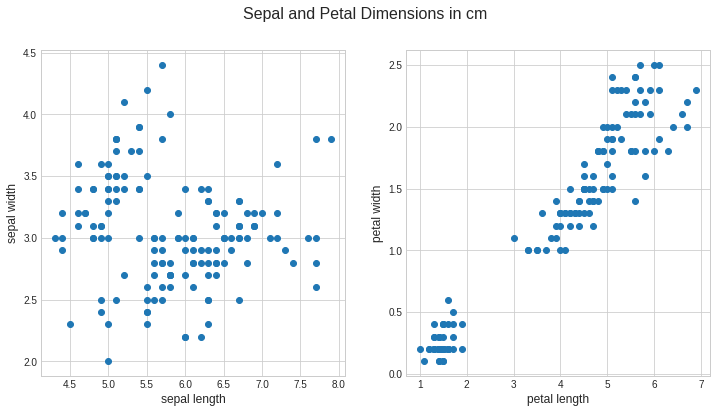

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# fig.tight_layout()
fig.suptitle('Sepal and Petal Dimensions in cm', fontsize=16)
axs[0].scatter(
    x=x['sepal_length_cm'],
    y=x['sepal_width_cm'],
)
axs[0].set_xlabel('sepal length', fontsize=12)
axs[0].set_ylabel('sepal width', fontsize=12)

axs[1].scatter(
    x=x['petal_length_cm'],
    y=x['petal_width_cm'],
)
axs[1].set_xlabel('petal length', fontsize=12)
axs[1].set_ylabel('petal width', fontsize=12);

# 3. Prepare data for clustering
## Scale data so features are weighed evenly

In [9]:
scaler = StandardScaler(with_mean=True, with_std=True)
x_scaled = scale_x(x=x, scaler=scaler)

# 4. Cluster with KMeans algorithm
## Find the "proper" number of clusters using KMeans Clustering

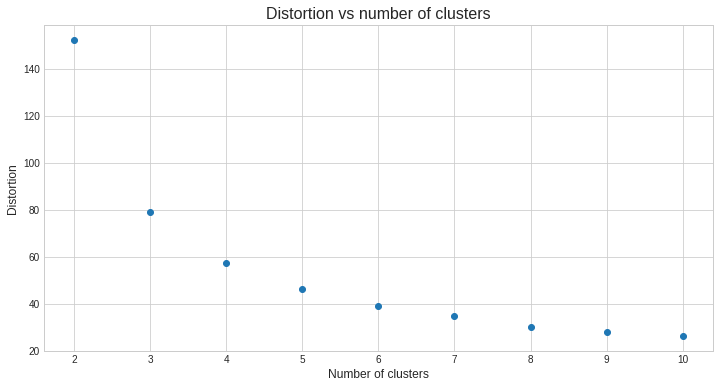

In [10]:
elbow_plot(x=x, clusters=range(2,11), random_state=random_state)

## Plot 2 KMeans clusters

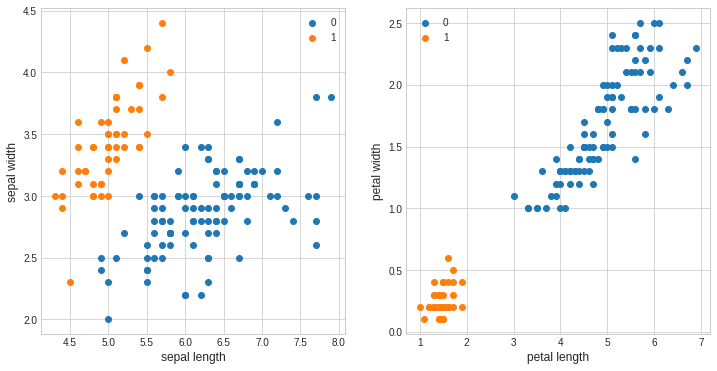

In [11]:
kmeans2 = KMeans(
    n_clusters=2,
    random_state=97,
)
kmeans2.fit(x_scaled)
plot_clusters(model=kmeans2)

## Plot 3 KMeans clusters

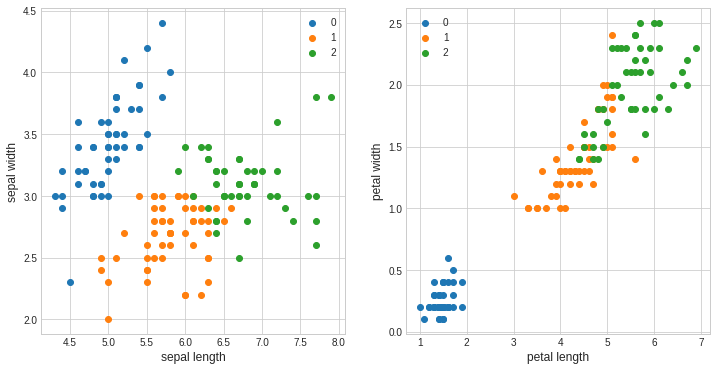

In [12]:
kmeans3 = KMeans(
    n_clusters=3,
    random_state=97,
)
kmeans3.fit(x_scaled)
plot_clusters(model=kmeans3)

## Plot 4 KMeans clusters

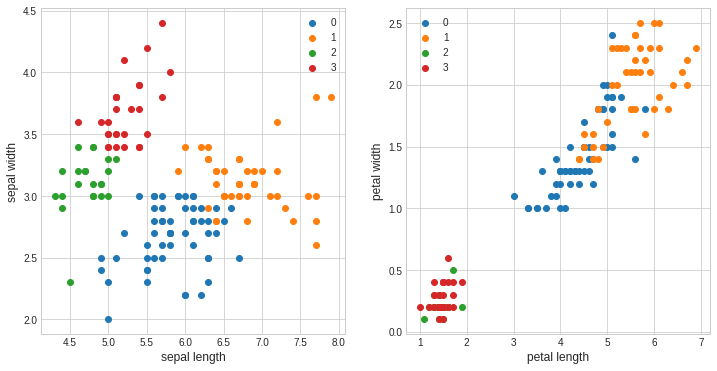

In [13]:
kmeans4 = KMeans(
    n_clusters=4,
    random_state=97,
)
kmeans4.fit(x_scaled)
plot_clusters(model=kmeans4)

# 5. Cluster with Agglomerative algorithm
## Find the "proper" number of clusters using Agglomerative Clustering

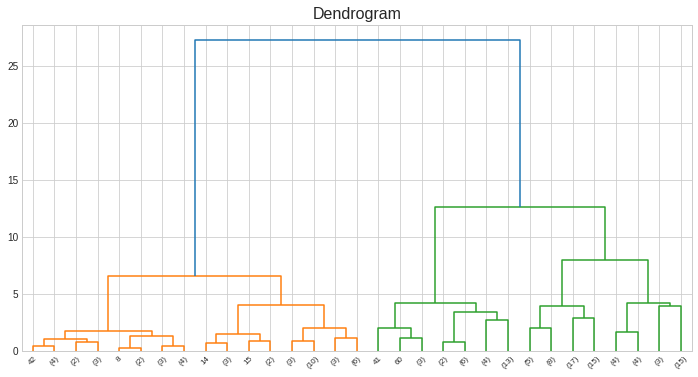

In [14]:
plot_dendrogram(
    model=AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(x_scaled),
    truncate_mode='level', 
    p=4,
)

## Plot 2 Agglomerative clusters

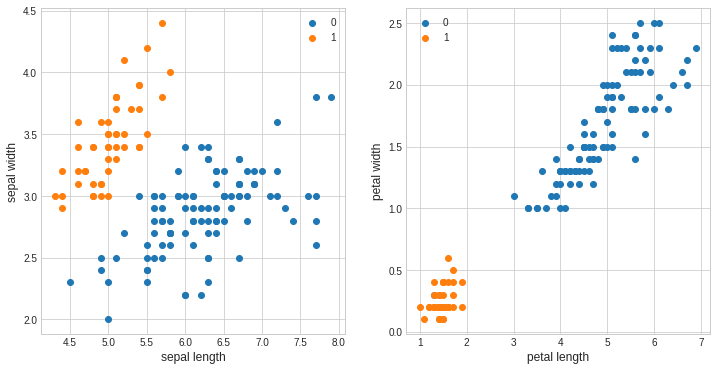

In [15]:
ag2 = AgglomerativeClustering(n_clusters=2)
ag2.fit(x_scaled)
plot_clusters(model=ag2)

## Plot 3 Agglomerative clusters

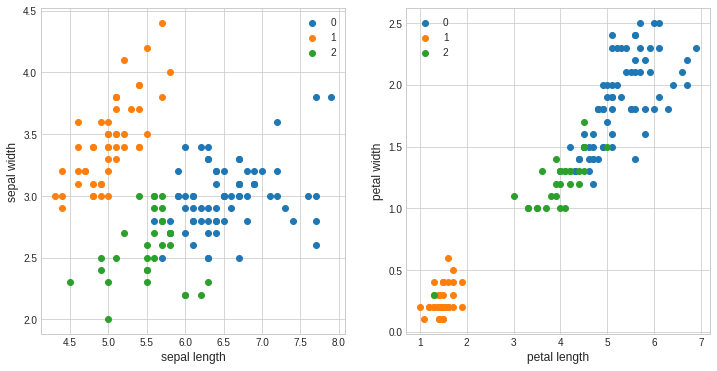

In [16]:
ag3 = AgglomerativeClustering(n_clusters=3)
ag3.fit(x_scaled)
plot_clusters(model=ag3)

## Plot 4 Agglomerative clusters

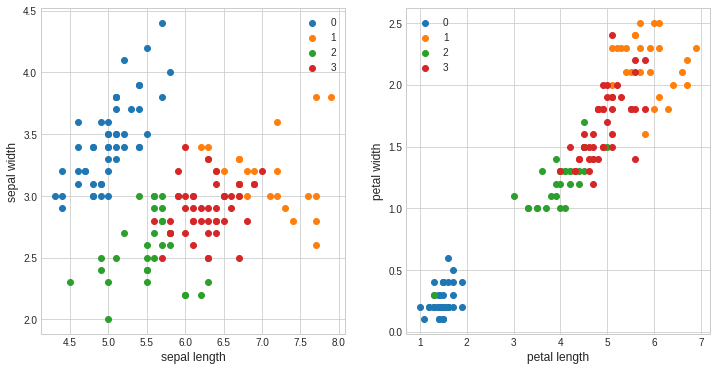

In [17]:
ag4 = AgglomerativeClustering(n_clusters=4)
ag4.fit(x_scaled)
plot_clusters(model=ag4)

# 6. Compare clustering results to iris species
## Look at iris species vs clustering results

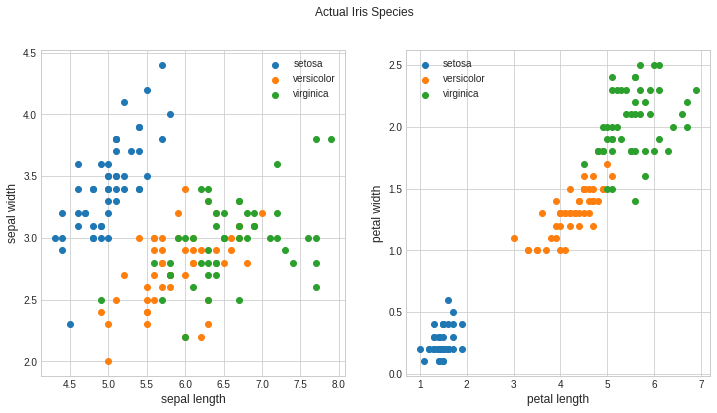

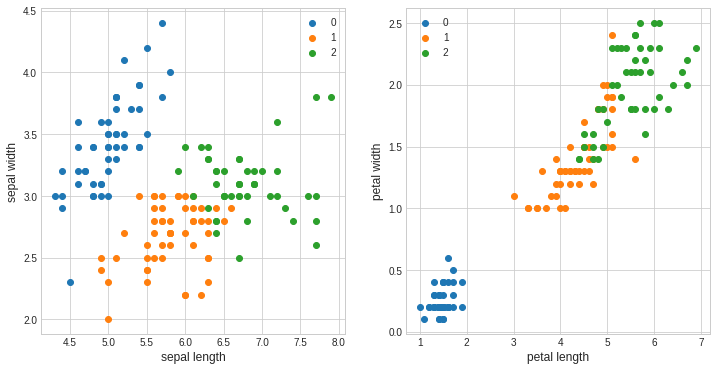

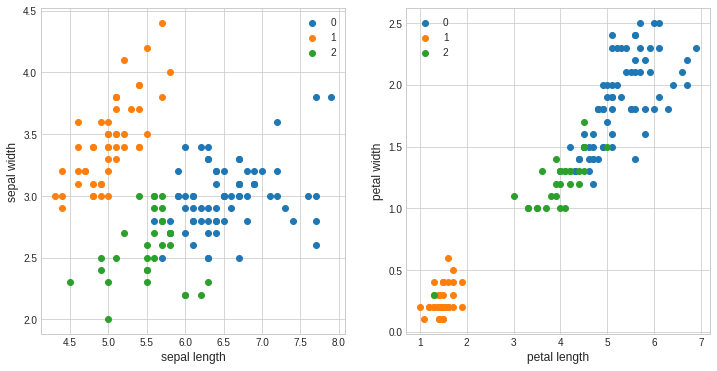

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for name in iris.target_names:
    axs[0].scatter(
        x=x.loc[y['target_name'] == name, 'sepal_length_cm'],
        y=x.loc[y['target_name'] == name, 'sepal_width_cm'],
        label=name
    )
    axs[1].scatter(
        x=x.loc[y['target_name'] == name, 'petal_length_cm'],
        y=x.loc[y['target_name'] == name, 'petal_width_cm'],
        label=name
    )
fig.suptitle('Actual Iris Species')
axs[0].set_xlabel('sepal length', fontsize=12)
axs[0].set_ylabel('sepal width', fontsize=12)
axs[1].set_xlabel('petal length', fontsize=12)
axs[1].set_ylabel('petal width', fontsize=12)
axs[0].legend()
axs[1].legend()

plot_clusters(model=kmeans3)
plot_clusters(model=ag3)

# 7. Descriptive analysis
## Descriptive analysis of clusters

In [19]:
data = {}

for n in np.unique(kmeans3.labels_):
    data[f'cluster_{n}'] = x.loc[kmeans3.labels_ == n, :].mean(axis=0)
data['global'] = x.mean(axis=0)
    
clusters = pd.DataFrame.from_dict(data)
clusters

,cluster_0,cluster_1,cluster_2,global
sepal_length_cm,5.006,5.801887,6.780851,5.843333
sepal_width_cm,3.428,2.673585,3.095745,3.057333
petal_length_cm,1.462,4.369811,5.510638,3.758000
petal_width_cm,0.246,1.413208,1.972340,1.199333


## Plot means

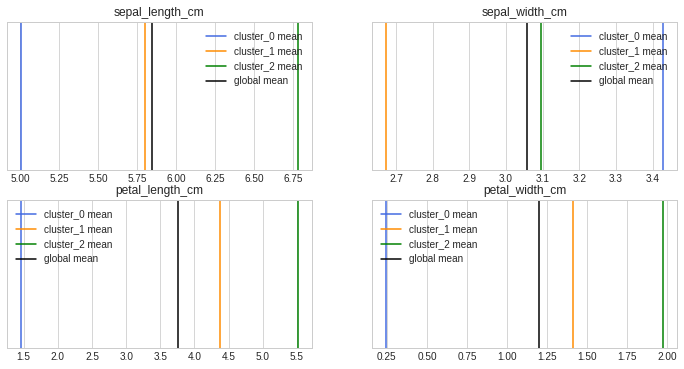

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
axs = axs.reshape(4,)
colors = ('royalblue', 'darkorange', 'green', 'k')
for i, part in enumerate(clusters.index):
    for j, cluster in enumerate(clusters.columns):
        axs[i].axvline(
            clusters.loc[part, cluster], 
            color=colors[j],
            label=cluster + ' mean',
    )
    axs[i].set_yticks([])
    axs[i].set_title(part, fontsize=12)
    axs[i].legend()